# Sigil image processing

In [9]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import os

## Old method

In [7]:
def process_sigil_for_engraving(input_path, output_path):
    """
    Process a colored sigil image to extract important information for engraving.
    
    Args:
        input_path: Path to input PNG file
        output_path: Path to save processed image
    """
    # Read the image
    img = cv2.imread(input_path)
    if img is None:
        print(f"Error: Could not read image at {input_path}")
        return False
    
    print(f"Processing: {input_path}")
    print(f"Original size: {img.shape[1]}x{img.shape[0]}")
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding for better edge detection
    # This works well for images with varying lighting
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Also try Otsu's thresholding for comparison
    _, otsu_thresh = cv2.threshold(
        blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    
    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # Morphological operations to clean up the image
    kernel = np.ones((2, 2), np.uint8)
    
    # Close small gaps in edges
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Dilate slightly to make lines more prominent for engraving
    edges_dilated = cv2.dilate(edges_closed, kernel, iterations=1)
    
    # Invert so lines are black on white (better for engraving preview)
    final = cv2.bitwise_not(edges_dilated)
    
    # Save all versions for comparison
    base_name = os.path.splitext(output_path)[0]
    
    cv2.imwrite(f"{base_name}_adaptive.png", adaptive_thresh)
    cv2.imwrite(f"{base_name}_otsu.png", otsu_thresh)
    cv2.imwrite(f"{base_name}_edges.png", edges)
    cv2.imwrite(f"{base_name}_final.png", final)
    
    print(f"Saved processed images:")
    print(f"  - {base_name}_adaptive.png (adaptive threshold)")
    print(f"  - {base_name}_otsu.png (Otsu threshold)")
    print(f"  - {base_name}_edges.png (edge detection)")
    print(f"  - {base_name}_final.png (final processed)")
    print()
    
    return True

In [8]:
im_haf = "images/hafkenscheid.png"
im_vsl = "images/Van_Slijpe_wapen.svg.png"

process_sigil_for_engraving(im_haf, "out_hafkenscheid.png")
process_sigil_for_engraving(im_vsl, "out_van_slijpe.png")

Processing: images/hafkenscheid.png
Original size: 512x512
Saved processed images:
  - out_hafkenscheid_adaptive.png (adaptive threshold)
  - out_hafkenscheid_otsu.png (Otsu threshold)
  - out_hafkenscheid_edges.png (edge detection)
  - out_hafkenscheid_final.png (final processed)

Processing: images/Van_Slijpe_wapen.svg.png
Original size: 330x371
Saved processed images:
  - out_van_slijpe_adaptive.png (adaptive threshold)
  - out_van_slijpe_otsu.png (Otsu threshold)
  - out_van_slijpe_edges.png (edge detection)
  - out_van_slijpe_final.png (final processed)



True

## New method


In [10]:
def process_sigil_for_engraving(input_path, threshold=200, save_outputs=False):
    """
    Process a colored sigil image to extract important information for engraving.
    Displays results inline in Jupyter notebook.
    
    Args:
        input_path: Path to input PNG file
        threshold: Brightness threshold (0-255). Lower = more sensitive to darker colors
        save_outputs: If True, also saves the images to disk
    """
    # Read the image
    img = cv2.imread(input_path)
    if img is None:
        print(f"Error: Could not read image at {input_path}")
        return None
    
    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print(f"Processing: {input_path}")
    print(f"Original size: {img.shape[1]}x{img.shape[0]}")
    print(f"Threshold value: {threshold}")
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply slight blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Simple threshold - anything darker than threshold becomes black
    _, simple_thresh = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)
    
    # Inverted threshold
    _, inverted_thresh = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY_INV)
    
    # Try multiple threshold values automatically
    thresholds = [150, 180, 200, 220, 240]
    thresh_results = []
    for t in thresholds:
        _, temp_thresh = cv2.threshold(blurred, t, 255, cv2.THRESH_BINARY_INV)
        thresh_results.append((t, temp_thresh))
    
    # K-means color quantization to find distinct regions
    img_float = np.float32(img.reshape((-1, 3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 5  # Number of colors to find
    _, labels, centers = cv2.kmeans(img_float, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    # Convert back to 8-bit
    centers = np.uint8(centers)
    quantized = centers[labels.flatten()].reshape(img.shape)
    quantized_rgb = cv2.cvtColor(quantized, cv2.COLOR_BGR2RGB)
    quantized_gray = cv2.cvtColor(quantized, cv2.COLOR_BGR2GRAY)
    
    # Find edges in the color transitions
    edges = cv2.Canny(quantized_gray, 30, 100)
    
    # Dilate edges to make them more visible
    kernel = np.ones((2, 2), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Combine the thresholded regions with edges
    combined = cv2.bitwise_or(inverted_thresh, edges_dilated)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Row 1: Original and main results
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img_rgb)
    ax1.set_title('Original Image', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(gray, cmap='gray')
    ax2.set_title('Grayscale', fontsize=12)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(quantized_rgb)
    ax3.set_title('Color Quantization (K=5)', fontsize=12)
    ax3.axis('off')
    
    # Row 2: Threshold comparisons
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.imshow(inverted_thresh, cmap='gray')
    ax4.set_title(f'Threshold {threshold} (Inverted)', fontsize=12)
    ax4.axis('off')
    
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.imshow(edges_dilated, cmap='gray')
    ax5.set_title('Edge Detection', fontsize=12)
    ax5.axis('off')
    
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.imshow(combined, cmap='gray')
    ax6.set_title('Combined (Regions + Edges)', fontsize=12, fontweight='bold', color='red')
    ax6.axis('off')
    
    # Row 3: Multiple threshold comparisons
    for idx, (t, thresh_img) in enumerate(thresh_results[:3]):
        ax = fig.add_subplot(gs[2, idx])
        ax.imshow(thresh_img, cmap='gray')
        ax.set_title(f'Auto Threshold {t}', fontsize=10)
        ax.axis('off')
    
    plt.suptitle(f'Sigil Processing Results - {input_path}', fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Optional: save outputs
    if save_outputs:
        import os
        base_name = os.path.splitext(input_path)[0]
        cv2.imwrite(f"{base_name}_combined.png", combined)
        print(f"Saved: {base_name}_combined.png")
    
    return {
        'original': img_rgb,
        'gray': gray,
        'quantized': quantized_rgb,
        'edges': edges_dilated,
        'combined': combined,
        'inverted_thresh': inverted_thresh
    }


def compare_thresholds(input_path, thresholds=[150, 170, 190, 210, 230]):
    """
    Display multiple threshold values side-by-side for easy comparison.
    
    Args:
        input_path: Path to input PNG file
        thresholds: List of threshold values to try
    """
    img = cv2.imread(input_path)
    if img is None:
        print(f"Error: Could not read image at {input_path}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    n_thresh = len(thresholds)
    fig, axes = plt.subplots(2, (n_thresh + 1) // 2, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, t in enumerate(thresholds):
        _, thresh_img = cv2.threshold(blurred, t, 255, cv2.THRESH_BINARY_INV)
        axes[idx].imshow(thresh_img, cmap='gray')
        axes[idx].set_title(f'Threshold = {t}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    # Hide extra subplots
    for idx in range(n_thresh, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Threshold Comparison - {input_path}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

Processing: images/hafkenscheid.png
Original size: 512x512
Threshold value: 120


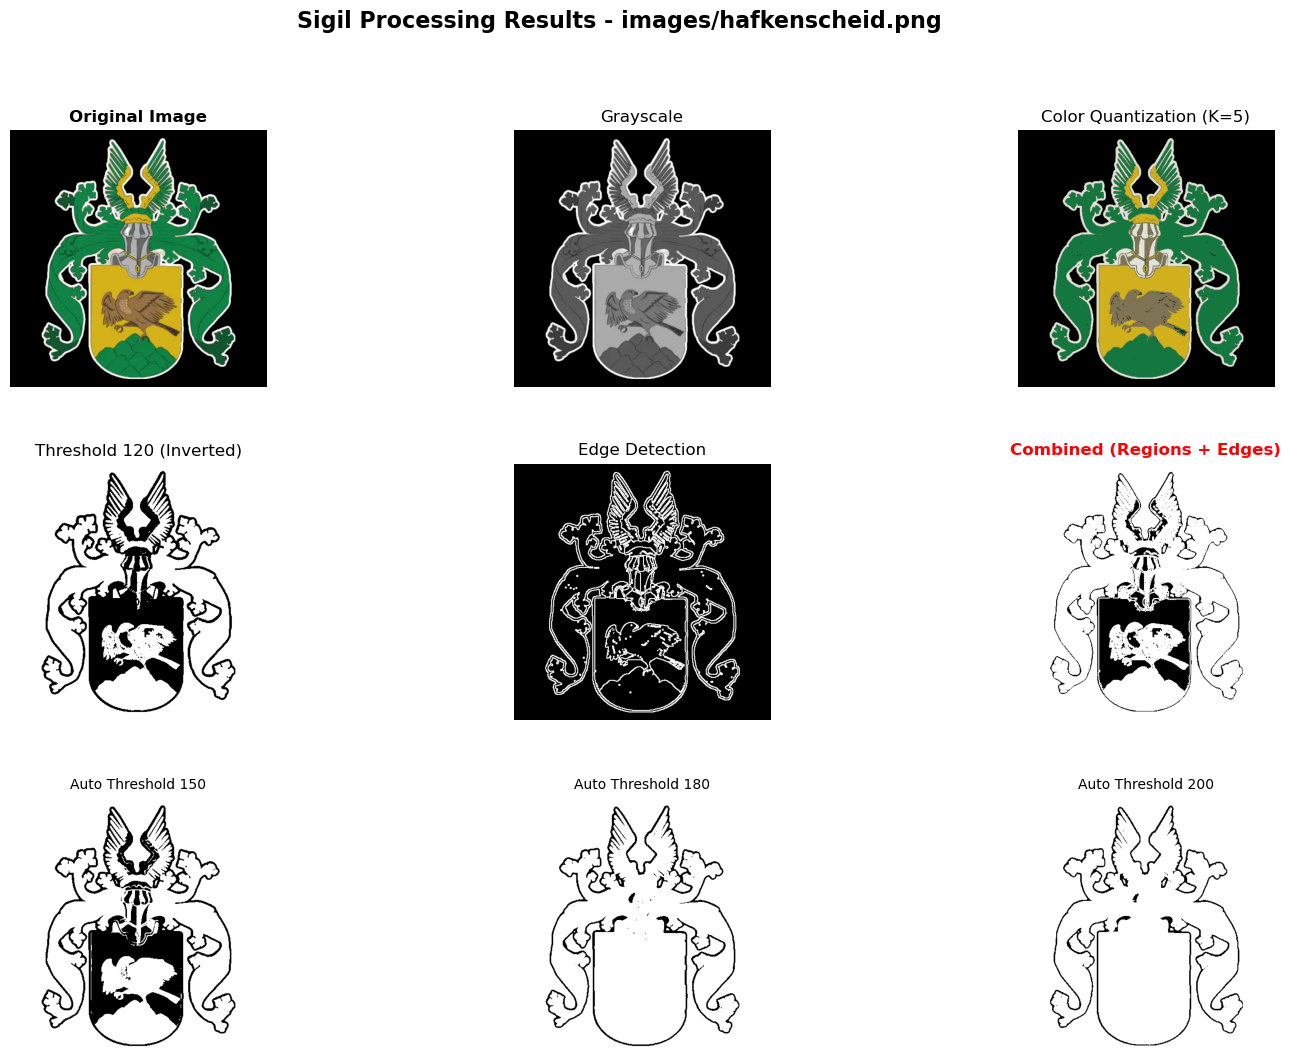

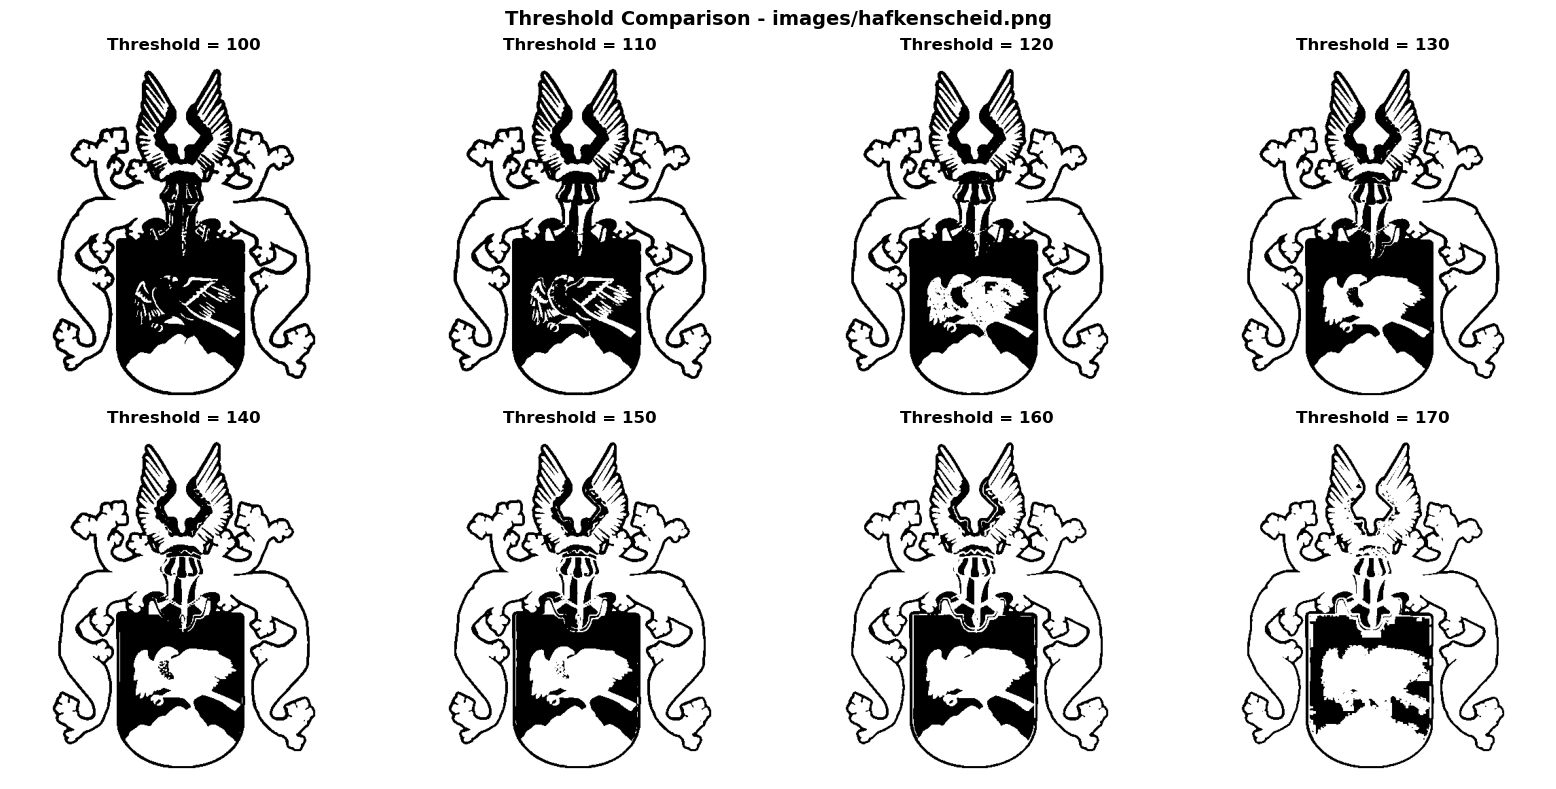

In [13]:
# Process the hafkenscheid sigil
im_haf = "images/hafkenscheid.png"
results = process_sigil_for_engraving(im_haf, threshold=120)

# Try different thresholds to find the best
compare_thresholds(im_haf, thresholds=[100, 110, 120, 130, 140, 150, 160, 170])

# # Process both sigils
# for filename in ["sigil1.png", "sigil2.png"]:
#     results = process_sigil_for_engraving(filename, threshold=200)